# Cross-subject decoding rule representations

#### Takuya Ito
#### 8/18/20
#### Results will be stochastic if don't use leave-one-out CV without resampling of trainset

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import multiprocessing as mp
import scipy.stats as stats
import os
os.environ['OMP_NUM_THREADS'] = str(1)
import statsmodels.sandbox.stats.multicomp as mc
import seaborn as sns
import h5py
import nibabel as nib
from importlib import reload
import tools

sns.set_style("whitegrid")
plt.rcParams["font.family"] = "FreeSans"


In [4]:
# Excluding 084
subjNums = ['013','014','016','017','018','021','023','024','026','027','028','030','031','032','033',
            '034','035','037','038','039','040','041','042','043','045','046','047','048','049','050',
            '053','055','056','057','058','062','063','066','067','068','069','070','072','074','075',
            '076','077','081','085','086','087','088','090','092','093','094','095','097','098','099',
            '101','102','103','104','105','106','108','109','110','111','112','114','115','117','119',
            '120','121','122','123','124','125','126','127','128','129','130','131','132','134','135',
            '136','137','138','139','140','141']



projectdir = '/home/ti61/f_mc1689_1/SRActFlow/'

# Using final partition
networkdef = np.loadtxt(projectdir + 'data/network_partition.txt')
networkorder = np.asarray(sorted(range(len(networkdef)), key=lambda k: networkdef[k]))
networkorder.shape = (len(networkorder),1)
# network mappings for final partition set
networkmappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 'aud':8, 'lan':6, 'dan':5, 'con':4, 'dmn':9, 
                   'pmulti':10, 'none1':11, 'none2':12}
networks = networkmappings.keys()

xticks = {}
reorderednetworkaffil = networkdef[networkorder]
for net in networks:
    netNum = networkmappings[net]
    netind = np.where(reorderednetworkaffil==netNum)[0]
    tick = np.max(netind)
    xticks[tick] = net

## General parameters/variables
nParcels = 360
nSubjs = len(subjNums)

glasserfile2 = projectdir + 'data/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'
glasser2 = nib.load(glasserfile2).get_data()
glasser2 = np.squeeze(glasser2)

sortednets = np.sort(list(xticks.keys()))
orderednetworks = []
for net in sortednets: orderednetworks.append(xticks[net])
    
networkpalette = ['royalblue','slateblue','paleturquoise','darkorchid','limegreen',
                  'lightseagreen','yellow','orchid','r','peru','orange','olivedrab']
networkpalette = np.asarray(networkpalette)

OrderedNetworks = ['VIS1','VIS2','SMN','CON','DAN','LAN','FPN','AUD','DMN','PMM','VMM','ORA']

## 1.0 Load data for all task rule domains

In [5]:
# gsr = True
nStims = 12
data_task = np.zeros((len(glasser2),nStims,len(subjNums)))
rules = ['Logic','Sensory','Motor']

scount = 0
for subj in subjNums:
    rulecount = 0
    for rule in rules:
        data_task[:,rulecount:(rulecount+4),scount] = tools.loadInputActivity(subj,rule)
        rulecount += 4
    scount += 1

/projects/f_mc1689_1/AnalysisTools/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


#### Run decoding 

In [6]:
nproc = 30
ncvs = 1
# rois = []
# rois.extend(np.where(networkdef==networkmappings['fpn'])[0])
# rois.extend(np.where(networkdef==networkmappings['con'])[0])
# rois.extend(np.where(networkdef==networkmappings['dan'])[0])
rois = np.arange(nParcels)

distances_baseline_allrules, rmatch, rmismatch, confusion_mats = tools.conditionDecodings(data_task, rois, motorOutput=False, ncvs=ncvs, effects=True, confusion=True, nproc=nproc)

#### Compute statistics

In [7]:
# rule = 'Logic'
statistics_allrules = np.zeros((len(rois),3)) # acc, q, acc_thresh
for roicount in range(len(rois)):
    ntrials = distances_baseline_allrules.shape[1]
    p = stats.binom_test(np.mean(distances_baseline_allrules[roicount,:])*ntrials,n=ntrials,p=1/float(nStims))
    if np.mean(distances_baseline_allrules[roicount,:])>1/float(nStims):
        p = p/2.0
    else:
        p = 1.0-p/2.0
        

    statistics_allrules[roicount,0] = np.mean(distances_baseline_allrules[roicount,:])
    statistics_allrules[roicount,1] = p

h0, qs = mc.fdrcorrection0(statistics_allrules[:,1])
for roicount in range(len(rois)):
    statistics_allrules[roicount,1] = qs[roicount]
    statistics_allrules[roicount,2] = h0[roicount]*statistics_allrules[roicount,0]
    
# Count number of significant ROIs for LH decoding
sig_ind = np.where(statistics_allrules[:,1]<0.05)[0]
print('Number of ROIs significant for all 12 rules:', sig_ind.shape[0])
print('Accuracies:', statistics_allrules[sig_ind,0])

#### Map back to surface
# Put all data into a single matrix (since we only run a single classification)
inputStim = np.zeros((glasser2.shape[0],3))

roicount = 0
for roi in rois:
    vertex_ind = np.where(glasser2==roi+1)[0]
    inputStim[vertex_ind,0] = statistics_allrules[roicount,0]
    inputStim[vertex_ind,1] = statistics_allrules[roicount,1]
    inputStim[vertex_ind,2] = statistics_allrules[roicount,2]

    roicount += 1

# np.savetxt('/projects3/SRActFlow/data/results/GroupfMRI/RuleDecoding/12Rule_Regions.csv', np.where(statistics_allrules[:,1]<0.05)[0], delimiter=',')
    
# #### 
# # Write file to csv and run wb_command
# outdir = '/projects3/SRActFlow/data/results/GroupfMRI/RuleDecoding/'
# filename = '12RuleDecoding'
# np.savetxt(outdir + filename + '.csv', inputStim,fmt='%s')
# wb_file = filename + '.dscalar.nii'
# wb_command = 'wb_command -cifti-convert -from-text ' + outdir + filename + '.csv ' + glasserfile2 + ' ' + outdir + wb_file + ' -reset-scalars'
# os.system(wb_command)


Number of ROIs significant for all 12 rules: 203
Accuracies: [0.1484375  0.14409722 0.140625   0.16232639 0.25086806 0.203125
 0.14583333 0.12934028 0.11371528 0.10243056 0.10850694 0.1015625
 0.1328125  0.11371528 0.10243056 0.10069444 0.12326389 0.11024306
 0.109375   0.109375   0.10503472 0.13368056 0.11284722 0.13888889
 0.13541667 0.1875     0.16840278 0.13194444 0.11892361 0.13107639
 0.11284722 0.10243056 0.21006944 0.16927083 0.21006944 0.16319444
 0.12847222 0.13541667 0.12065972 0.10850694 0.11805556 0.11024306
 0.13194444 0.11631944 0.11979167 0.11805556 0.10069444 0.11458333
 0.11371528 0.109375   0.1171875  0.1171875  0.15451389 0.10503472
 0.11545139 0.13888889 0.11631944 0.10329861 0.11284722 0.10850694
 0.11197917 0.12847222 0.16753472 0.11197917 0.11284722 0.10677083
 0.13194444 0.10243056 0.109375   0.10677083 0.14583333 0.12065972
 0.14496528 0.14236111 0.12847222 0.09982639 0.109375   0.11892361
 0.1015625  0.18402778 0.16232639 0.10503472 0.13802083 0.13020833
 0.1

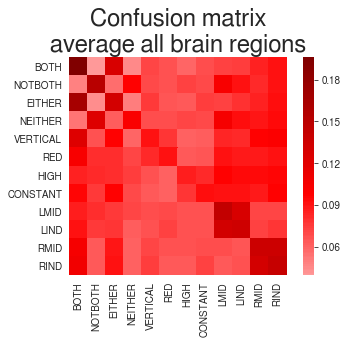

In [35]:
ax = sns.heatmap(np.mean(np.asarray(confusion_mats)[h0,:,:],axis=0),center=0,square=True,cmap='seismic')
plt.title('Confusion matrix\naverage all brain regions',fontsize=24)
plt.xticks(np.arange(0.5,12.5),['BOTH','NOTBOTH','EITHER','NEITHER','VERTICAL','RED','HIGH','CONSTANT','LMID','LIND','RMID','RIND'],rotation=90);
plt.yticks(np.arange(0.5,12.5),['BOTH','NOTBOTH','EITHER','NEITHER','VERTICAL','RED','HIGH','CONSTANT','LMID','LIND','RMID','RIND'],rotation=0);


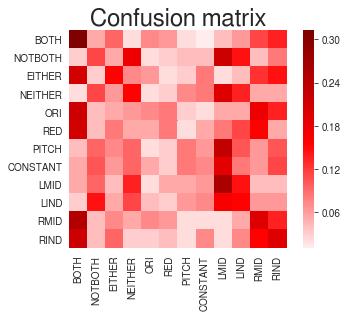

In [30]:
ax = sns.heatmap(confusion_mats[9],center=0,square=True,cmap='seismic')
plt.title('Confusion matrix',fontsize=24)
plt.xticks(np.arange(0.5,12.5),['BOTH','NOTBOTH','EITHER','NEITHER','ORI','RED','PITCH','CONSTANT','LMID','LIND','RMID','RIND'],rotation=90);
plt.yticks(np.arange(0.5,12.5),['BOTH','NOTBOTH','EITHER','NEITHER','ORI','RED','PITCH','CONSTANT','LMID','LIND','RMID','RIND'],rotation=0);


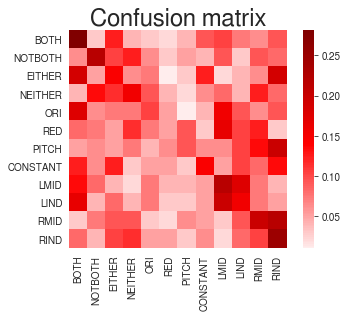

In [31]:
ax = sns.heatmap(confusion_mats[189],center=0,square=True,cmap='seismic')
plt.title('Confusion matrix',fontsize=24)
plt.xticks(np.arange(0.5,12.5),['BOTH','NOTBOTH','EITHER','NEITHER','ORI','RED','PITCH','CONSTANT','LMID','LIND','RMID','RIND'],rotation=90);
plt.yticks(np.arange(0.5,12.5),['BOTH','NOTBOTH','EITHER','NEITHER','ORI','RED','PITCH','CONSTANT','LMID','LIND','RMID','RIND'],rotation=0);

___

# Create surface map but excluding hidden regions from 12 rule map

In [49]:
rule12_regions = np.loadtxt('/projects3/SRActFlow/data/results/GroupfMRI/RuleDecoding/12Rule_Regions.csv',delimiter=',')
hidden_regions = np.loadtxt('/projects3/SRActFlow/data/results/GroupfMRI/RSA/RSA_Similarity_SortedRegions2.txt',delimiter=',')
hidden_regions = hidden_regions[:10] # only top 10
    
overlapping_regions = np.in1d(rule12_regions,hidden_regions)==False
rule12_regions = rule12_regions[overlapping_regions]
    
    
#### Map back to surface
# Put all data into a single matrix (since we only run a single classification)
rule64k = np.zeros((glasser2.shape[0],1))
# hidden64k = np.zeros((glasser2.shape[0],1))

roicount = 0
for roi in rule12_regions:
    vertex_ind = np.where(glasser2==roi+1)[0]
    rule64k[vertex_ind,0] = True
    
# roicount = 0
# for roi in hidden_regions:
#     vertex_ind = np.where(glasser2==roi+1)[0]
#     hidden64k[vertex_ind,0] = True
    
    
# overlapping = np.where(np.in1d(np.where(rule64k)[0],np.where(hidden64k)[0]))[0]    
# rule64k[overlapping] = False

#### 
# Write file to csv and run wb_command
outdir = '/projects3/SRActFlow/data/results/GroupfMRI/RuleDecoding/'
filename = '12RuleDecoding_withoutHidden'
np.savetxt(outdir + filename + '.csv',rule64k,fmt='%s')
wb_file = filename + '.dscalar.nii'
wb_command = 'wb_command -cifti-convert -from-text ' + outdir + filename + '.csv ' + glasserfile2 + ' ' + outdir + wb_file + ' -reset-scalars'
os.system(wb_command)


0